# Making the Natural Color RGB image
Tips from Rick Kohrs

The stretches are   
0 -> breakpt, 0 -> 10  
breakpoint -> 255, 11->255  

- Red breakpoint is 33
- Green breakpoint is 40
- Blue breakpoint is 50


In [11]:
from goes2go.data import goes_latest, goes_nearesttime
from goes2go.rgb import normalize, TrueColor, NaturalColor
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from toolbox.cartopy_tools import common_features

In [2]:
g = goes_nearesttime('2021-01-01 18:00', satellite=16, product='ABI', domain='F')
#g = goes_latest(satellite=16, product='ABI')

 _______________________________
 | Satellite: noaa-goes16      |
 |   Product: ABI-L2-MCMIPF    |
 |    Domain: F                |
📦 Finished downloading [1] files to [/p/home/blaylock/data/noaa-goes16/ABI-L2-MCMIPF].                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [3]:
g

<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 5424, y: 5424)
Coordinates: (12/41)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1518 ... -0.1518
  * x                                       (x) float32 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
    dataset_name                            <U74 'OR_ABI-L2-MCMIPF-M6_G16_s20...
    date_created                            <U22 '2021-01-01T18:10:01.5Z'
    time_coverage_start                     <U22 '2021-01-01T18:00:20.9Z'
    time_coverage_end                       <U22 '2021-01-01T18:09:51.7Z'
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/25)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    keywords:                  ATMOSPHERE > ATMOSPHERIC RADIATION > REFLECTAN...
    cdm_data_type:             Image
    processing_level:          National Aeronautics and Space Administration ...
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        e1f9cf31-8714-4755-a58d-78a66bb694f4

In [8]:
# Original TrueColor
tc = TrueColor(g, night_IR=False)

In [10]:
nc = NaturalColor(g, night_IR=False)

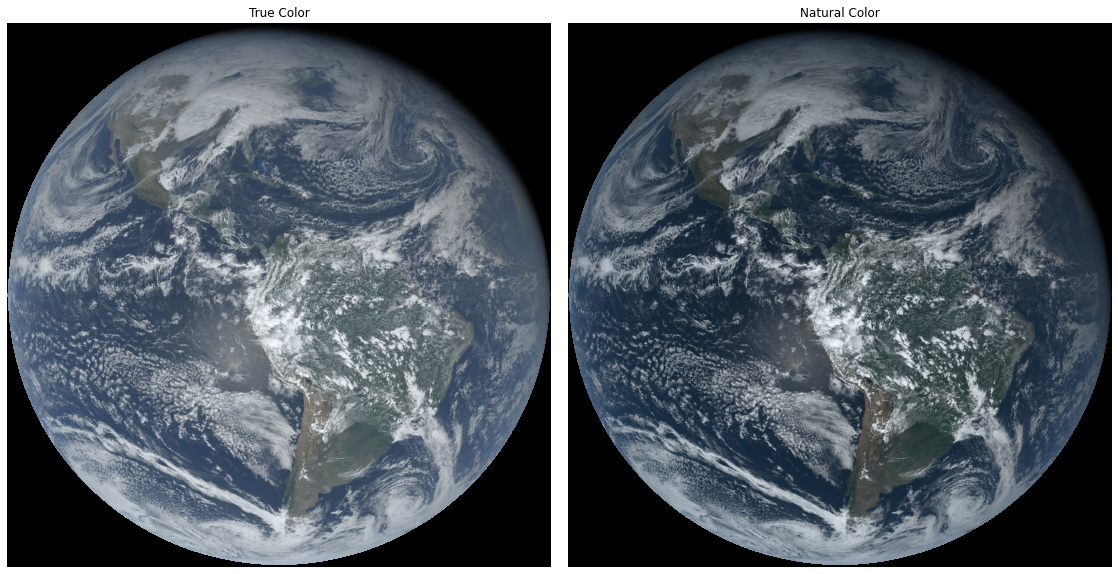

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[20,10])

ax1.imshow(tc.TrueColor)
ax1.set_title('True Color')
ax1.axis('off')

ax2.imshow(nc.NaturalColor)
ax2.set_title('Natural Color')
ax2.axis('off')

plt.subplots_adjust(wspace=0.01)

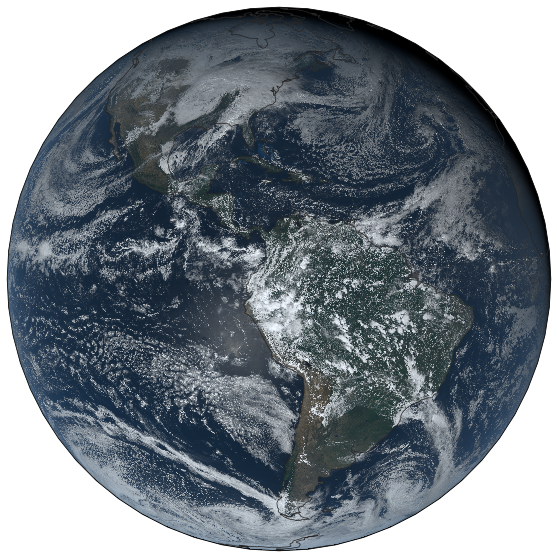

In [22]:
ax = common_features(crs=tc.attrs['crs'], figsize=[10,10])
ax.imshow(nc.NaturalColor, **nc.attrs['imshow_kwargs'])

In [17]:
tc.attrs

{'description': 'True Color',
 'crs': <cartopy.crs.Geostationary at 0x2ae3c10ee900>,
 'orbital_slot': 'GOES-East',
 'platform_ID': 'G16',
 'scene_id': 'Full Disk',
 'spatial_resolution': '2km at nadir',
 'instrument_type': 'GOES R Series Advanced Baseline Imager',
 'title': 'ABI L2 Cloud and Moisture Imagery',
 'imshow_kwargs': {'extent': [-5433893.0, 5433893.0, -5433893.0, 5433893.0],
  'transform': <cartopy.crs.Geostationary at 0x2ae3c10ee900>,
  'origin': 'upper',
  'interpolation': 'none'}}

In [4]:
# These are the albedo value
R = g.CMI_C02
G = g.CMI_C03
B = g.CMI_C01

# Scale the "Green" Channel
G = .45 * R + .1 * G + .45 *B

In [5]:
# Convert Albedo to Brightness, ranging from 0-255 K
R_b = np.sqrt(R*100) * 25.5
G_b = np.sqrt(G*100) * 25.5
B_b = np.sqrt(B*100) * 25.5

In [6]:
def breakpoint_stretch(C, breakpoint):
    """
    Constrast stretching by break point (Rick Kohrs)
    """
    lower = normalize(C, 0, 10)     # Low end
    upper = normalize(C, 10, 255)   # High end
    
    # Combine the two datasets
    # This works because if upper=1 and lower==.7, then 
    # that means the upper value was out of range and the 
    # vaule for the lower pass was used instead.
    combined = np.minimum(lower, upper)
    
    return combined

In [7]:
R_s = breakpoint_stretch(R_b, 33)
G_s = breakpoint_stretch(G_b, 40)
B_s = breakpoint_stretch(B_b, 50)

In [72]:
R_b.max().data

array(260.12924, dtype=float32)

In [8]:
#RGB = np.dstack([R_bn, GG_bn, B_bn])
#RGB = np.dstack([R, G, B])

#RGB = np.dstack([R_bc, GG_bc, B_bc])

RGB = np.dstack([R_s, G_s, B_s])

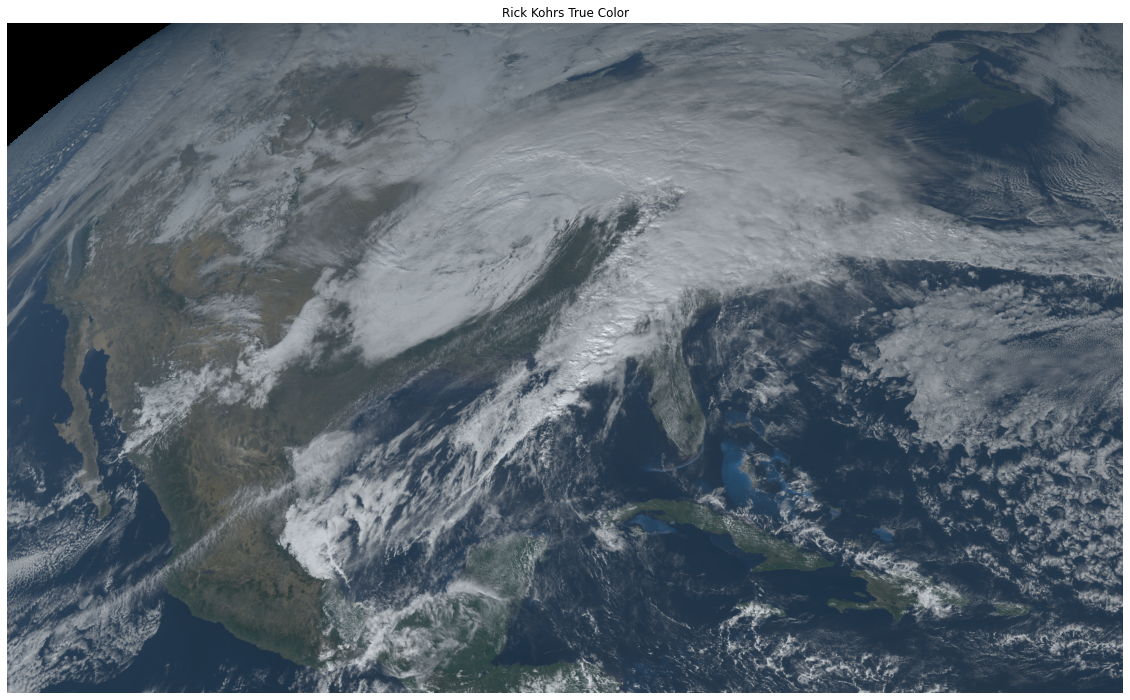

In [9]:
plt.figure(figsize=[20,20])
plt.title('Rick Kohrs True Color')
plt.axis('off')

plt.imshow(RGB)

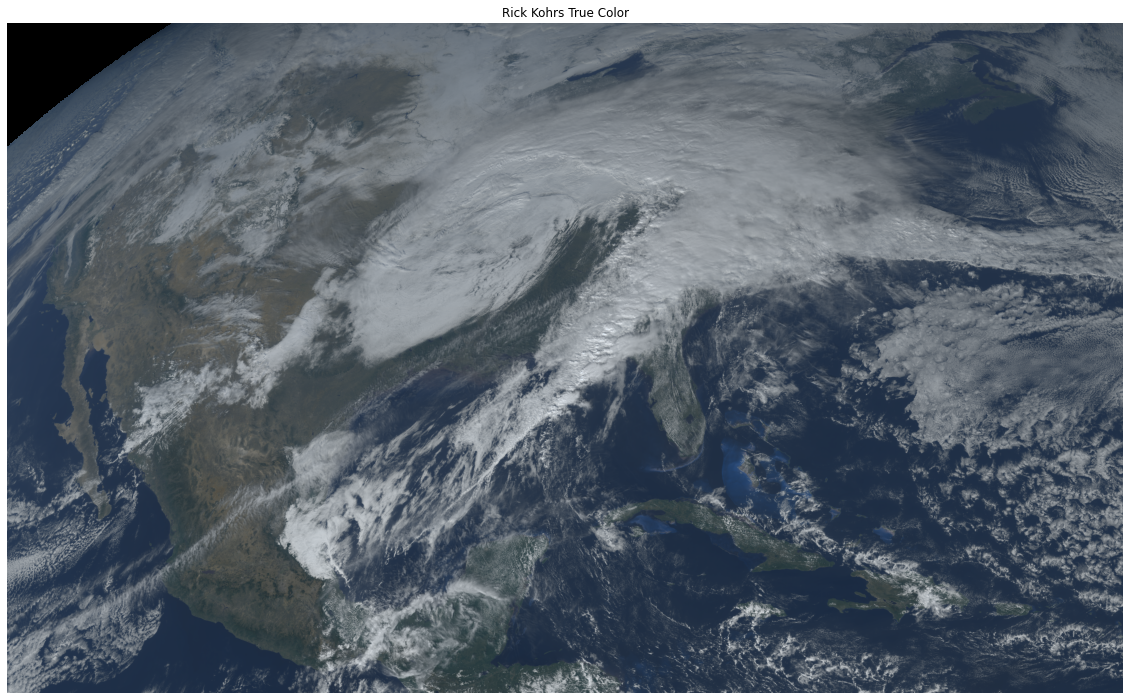

In [90]:
plt.figure(figsize=[20,20])
plt.title('Rick Kohrs True Color')
plt.axis('off')

plt.imshow(np.power(RGB, 1.05))

Gamma Correction: 🌒 Darken image
finished gamma= 0.5
Gamma Correction: 🌒 Darken image
finished gamma= 0.8
Gamma Correction: 🌓 Gamma=1. No correction made.
finished gamma= 1
Gamma Correction: 🌔 Lighten image
finished gamma= 1.2
Gamma Correction: 🌔 Lighten image
finished gamma= 1.5


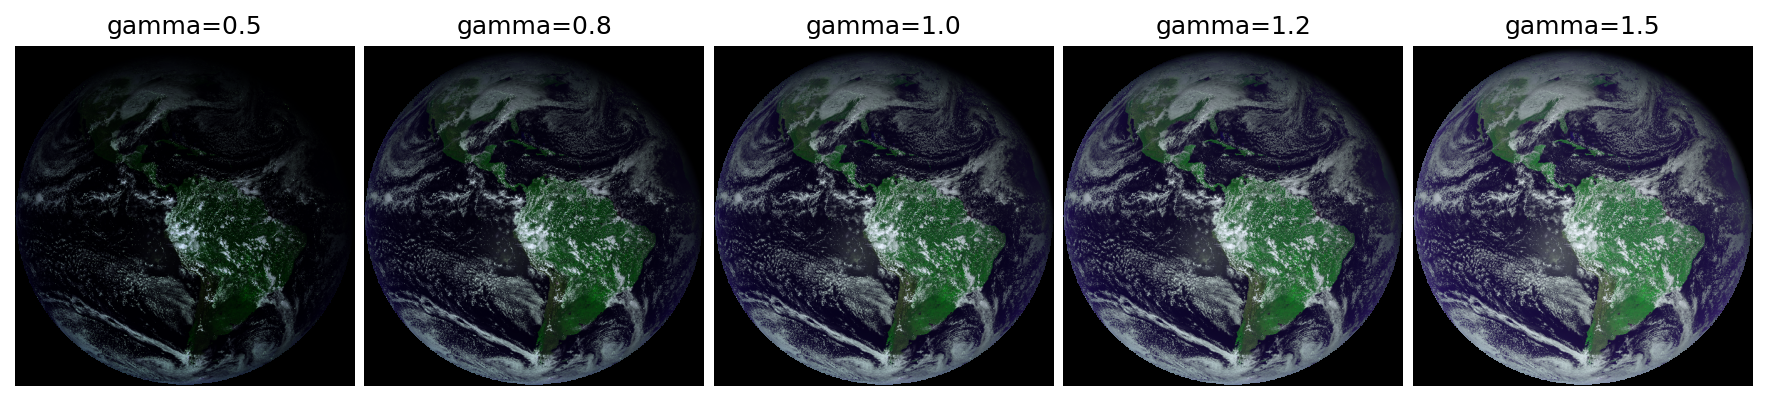

In [20]:
gammas = [.5, .8, 1, 1.2, 1.5]

fig, axes = plt.subplots(1,len(gammas), figsize=[15,3], dpi=150)
for gamma, ax in zip(gammas, axes):
    nc = NaturalColor(g.thin(10), gamma)
    ax.imshow(nc.NaturalColor)
    ax.axis('off')
    ax.set_title(f'gamma={gamma:.1f}')
    print('finished gamma=', gamma)
plt.subplots_adjust(wspace=.01)
    

Gamma Correction: 🌔 Lighten image
Gamma Correction: 🌔 Lighten image
Gamma Correction: 🌔 Lighten image
finished gamma= 1.3
Gamma Correction: 🌔 Lighten image
Gamma Correction: 🌔 Lighten image
Gamma Correction: 🌔 Lighten image
finished gamma= 1.7
Gamma Correction: 🌔 Lighten image
Gamma Correction: 🌔 Lighten image
Gamma Correction: 🌔 Lighten image
finished gamma= 2.2
Gamma Correction: 🌔 Lighten image
Gamma Correction: 🌔 Lighten image
Gamma Correction: 🌔 Lighten image
finished gamma= 2.7
Gamma Correction: 🌔 Lighten image
Gamma Correction: 🌔 Lighten image
Gamma Correction: 🌔 Lighten image
finished gamma= 3.2


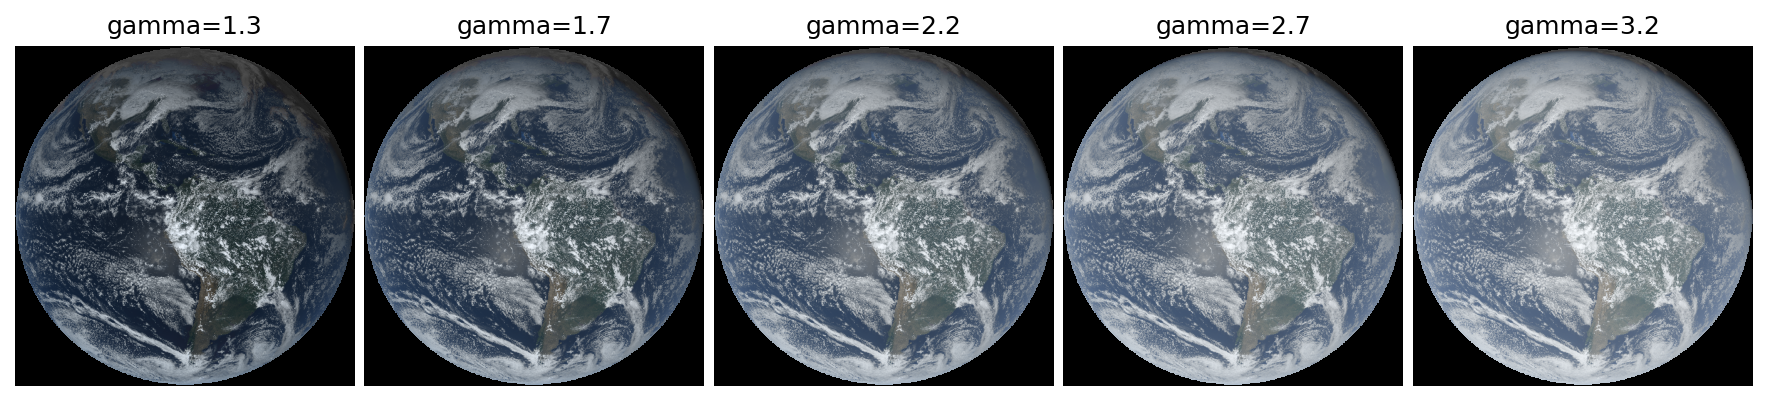

In [24]:
gammas = [1.3, 1.7, 2.2, 2.7, 3.2]

fig, axes = plt.subplots(1,len(gammas), figsize=[15,3], dpi=150)
for gamma, ax in zip(gammas, axes):
    nc = TrueColor(g.thin(10), gamma)
    ax.imshow(nc.TrueColor)
    ax.axis('off')
    ax.set_title(f'gamma={gamma:.1f}')
    print('finished gamma=', gamma)
plt.subplots_adjust(wspace=.01)
    

In [2]:
from goes2go.data import goes_latest
from goes2go.rgb import NormalizedBurnRatio

import matplotlib.pyplot as plt

In [3]:
C = goes_latest(product='ABI')

 _______________________________
 | Satellite: noaa-goes17      |
 |   Product: ABI-L2-MCMIPC    |
 |    Domain: C                |
📦 Finished downloading [1] files to [/p/home/blaylock/data/noaa-goes17/ABI-L2-MCMIPC].                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [7]:
a = NormalizedBurnRatio(C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


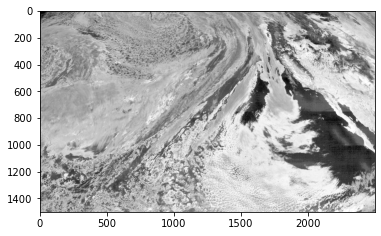

In [11]:
plt.imshow(a.NightFogDifference)

In [6]:
C.band_wavelength_C06

<xarray.DataArray 'band_wavelength_C06' (band: 1)>
array([2.25], dtype=float32)
Coordinates:
    t                    datetime64[ns] 2021-01-14T22:02:36.665750016
    y_image              float32 0.08624
    x_image              float32 0.0
    band_wavelength_C01  (band) float32 0.47
    band_wavelength_C02  (band) float32 0.64
    band_wavelength_C03  (band) float32 0.87
    band_wavelength_C04  (band) float32 1.38
    band_wavelength_C05  (band) float32 1.61
    band_wavelength_C06  (band) float32 2.25
    band_wavelength_C07  (band) float32 3.89
    band_wavelength_C08  (band) float32 6.17
    band_wavelength_C09  (band) float32 6.93
    band_wavelength_C10  (band) float32 7.34
    band_wavelength_C11  (band) float32 8.44
    band_wavelength_C12  (band) float32 9.61
    band_wavelength_C13  (band) float32 10.33
    band_wavelength_C14  (band) float32 11.19
    band_wavelength_C15  (band) float32 12.27
    band_wavelength_C16  (band) float32 13.27
    band_id_C01          (band) int8 1
    band_id_C02          (band) int8 2
    band_id_C03          (band) int8 3
    band_id_C04          (band) int8 4
    band_id_C05          (band) int8 5
    band_id_C06          (band) int8 6
    band_id_C07          (band) int8 7
    band_id_C08          (band) int8 8
    band_id_C09          (band) int8 9
    band_id_C10          (band) int8 10
    band_id_C11          (band) int8 11
    band_id_C12          (band) int8 12
    band_id_C13          (band) int8 13
    band_id_C14          (band) int8 14
    band_id_C15          (band) int8 15
    band_id_C16          (band) int8 16
    dataset_name         <U74 'OR_ABI-L2-MCMIPC-M6_G17_s20210142201177_e20210...
    date_created         <U22 '2021-01-14T22:04:08.1Z'
    time_coverage_start  <U22 '2021-01-14T22:01:17.7Z'
    time_coverage_end    <U22 '2021-01-14T22:03:55.6Z'
Dimensions without coordinates: band
Attributes:
    long_name:      ABI band 6 central wavelength
    standard_name:  sensor_band_central_radiation_wavelength
    units:          um

In [2]:
from goes2go.data import goes_timerange

/p/home/blaylock/BB_python/goes2go/goes2go/__init__.py:13: UserWarning: goes2go xarray accessors could not be imported.
  warnings.warn("goes2go xarray accessors could not be imported.")


In [2]:
start = '2021-01-01 00:30'
end = '2021-01-01 01:30'

In [3]:
g = goes_timerange(start, end, satellite='goes16', product='ABI', return_as='xarray')

 _______________________________
 | Satellite: noaa-goes16      |
 |   Product: ABI-L2-MCMIPC    |
 |    Domain: C                |
📦 Finished downloading [12] files to [/p/home/blaylock/data/noaa-goes16/ABI-L2-MCMIPC].                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [4]:
g

<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 12, x: 2500, y: 1500)
Coordinates: (12/41)
  * t                                       (t) datetime64[ns] 2021-01-01T00:...
  * y                                       (y) float32 0.1282 ... 0.04427
  * x                                       (x) float32 -0.1013 ... 0.03861
    y_image                                 float32 0.08624
    x_image                                 float32 -0.03136
    band_wavelength_C01                     (band) float32 0.47
    ...                                      ...
    band_id_C15                             (band) int8 15
    band_id_C16                             (band) int8 16
    dataset_name                            (t) <U74 'OR_ABI-L2-MCMIPC-M6_G16...
    date_created                            (t) <U22 '2021-01-01T00:34:10.3Z'...
    time_coverage_start                     (t) <U22 '2021-01-01T00:31:17.6Z'...
    time_coverage_end                       (t) <U22 '2021-01-01T00:33:56.1Z'...
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables: (12/124)
    CMI_C01                                 (t, y, x) float32 nan nan ... 0.0
    DQF_C01                                 (t, y, x) float32 nan nan ... 0.0
    CMI_C02                                 (t, y, x) float32 nan ... 0.0003175
    DQF_C02                                 (t, y, x) float32 nan nan ... 0.0
    CMI_C03                                 (t, y, x) float32 nan nan ... 0.0
    DQF_C03                                 (t, y, x) float32 nan nan ... 0.0
    ...                                      ...
    mean_brightness_temperature_C16         (t) float64 259.5 259.5 ... 259.5
    std_dev_brightness_temperature_C16      (t) float64 16.32 16.31 ... 16.17
    percent_uncorrectable_GRB_errors        (t) float64 0.0 0.0 0.0 ... 0.0 0.0
    percent_uncorrectable_L0_errors         (t) float64 0.0 0.0 0.0 ... 0.0 0.0
    dynamic_algorithm_input_data_container  (t) int32 -2147483647 ... -214748...
    algorithm_product_version_container     (t) int32 -2147483647 ... -214748...
Attributes: (12/25)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    keywords:                  ATMOSPHERE > ATMOSPHERIC RADIATION > REFLECTAN...
    cdm_data_type:             Image
    processing_level:          National Aeronautics and Space Administration ...
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        5b123f1c-4356-4047-bec0-16c9c3bdb3ed

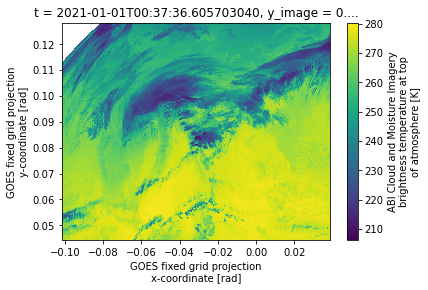

In [11]:
g.CMI_C16.isel(t=1).plot()

In [6]:
import xarray

In [7]:
xarray.__version__

'0.18.2'

In [12]:
g = goes_timerange(start, end, satellite='goes16', product='ABI')

 _______________________________
 | Satellite: noaa-goes16      |
 |   Product: ABI-L2-MCMIPC    |
 |    Domain: C                |
📦 Finished downloading [12] files to [/p/home/blaylock/data/noaa-goes16/ABI-L2-MCMIPC].                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [13]:
g

file                   start  \
0   noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L... 2021-01-01 00:31:17.600   
1   noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L... 2021-01-01 00:36:17.600   
2   noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L... 2021-01-01 00:41:17.600   
3   noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L... 2021-01-01 00:46:17.600   
4   noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L... 2021-01-01 00:51:17.600   
5   noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L... 2021-01-01 00:56:17.600   
6   noaa-goes16/ABI-L2-MCMIPC/2021/001/01/OR_ABI-L... 2021-01-01 01:01:17.600   
7   noaa-goes16/ABI-L2-MCMIPC/2021/001/01/OR_ABI-L... 2021-01-01 01:06:17.600   
8   noaa-goes16/ABI-L2-MCMIPC/2021/001/01/OR_ABI-L... 2021-01-01 01:11:17.600   
9   noaa-goes16/ABI-L2-MCMIPC/2021/001/01/OR_ABI-L... 2021-01-01 01:16:17.600   
10  noaa-goes16/ABI-L2-MCMIPC/2021/001/01/OR_ABI-L... 2021-01-01 01:21:17.600   
11  noaa-goes16/ABI-L2-MCMIPC/2021/001/01/OR_ABI-L... 2021-01-01 01:26:17.600   

                       end                creation  
0  2021-01-01 00:33:56.100 2021-01-01 00:34:10.300  
1  2021-01-01 00:38:55.500 2021-01-01 00:39:09.900  
2  2021-01-01 00:43:56.100 2021-01-01 00:44:09.200  
3  2021-01-01 00:48:56.100 2021-01-01 00:49:09.600  
4  2021-01-01 00:53:55.500 2021-01-01 00:54:10.500  
5  2021-01-01 00:58:55.500 2021-01-01 00:59:09.000  
6  2021-01-01 01:03:54.900 2021-01-01 01:04:10.200  
7  2021-01-01 01:08:56.100 2021-01-01 01:09:09.400  
8  2021-01-01 01:13:55.500 2021-01-01 01:14:10.300  
9  2021-01-01 01:18:56.100 2021-01-01 01:19:09.600  
10 2021-01-01 01:23:54.900 2021-01-01 01:24:10.200  
11 2021-01-01 01:28:55.500 2021-01-01 01:29:09.000

In [14]:
import xarray as xr

In [15]:
your_base = '/p/home/blaylock/data'

In [20]:
for i in g.file:
    print(your_base+'/'+i)

/p/home/blaylock/data/noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L2-MCMIPC-M6_G16_s20210010031176_e20210010033561_c20210010034103.nc
/p/home/blaylock/data/noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L2-MCMIPC-M6_G16_s20210010036176_e20210010038555_c20210010039099.nc
/p/home/blaylock/data/noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L2-MCMIPC-M6_G16_s20210010041176_e20210010043561_c20210010044092.nc
/p/home/blaylock/data/noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L2-MCMIPC-M6_G16_s20210010046176_e20210010048561_c20210010049096.nc
/p/home/blaylock/data/noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L2-MCMIPC-M6_G16_s20210010051176_e20210010053555_c20210010054105.nc
/p/home/blaylock/data/noaa-goes16/ABI-L2-MCMIPC/2021/001/00/OR_ABI-L2-MCMIPC-M6_G16_s20210010056176_e20210010058555_c20210010059090.nc
/p/home/blaylock/data/noaa-goes16/ABI-L2-MCMIPC/2021/001/01/OR_ABI-L2-MCMIPC-M6_G16_s20210010101176_e20210010103549_c20210010104102.nc
/p/home/blaylock/data/noaa-goes16/ABI-L2-MCMIPC/2021/00

In [ ]:
from goes2go.data import goes_latest
from goes2go.rgb import *

import goes2go.accessors

In [2]:
g = goes_latest(satellite='G17', product='abi')

 _______________________________
 | Satellite: noaa-goes17      |
 |   Product: ABI-L2-MCMIPC    |
 |    Domain: C                |
📦 Finished downloading [1] files to [/p/home/blaylock/data/noaa-goes17/ABI-L2-MCMIPC].                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [3]:
g.geo.get_imshow_kwargs

AttributeError: 'NoneType' object has no attribute 'data'

In [ ]:
g.geo.sat_h

In [5]:
g.geo.TrueColor()

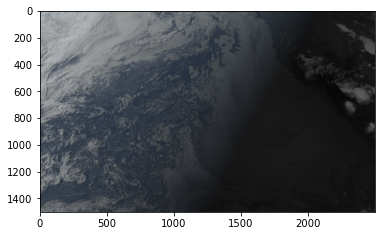

In [6]:
plt.imshow(g.TrueColor)

In [7]:
dir(g.geo)

['AirMass',
 'Ash',
 'DayCloudConvection',
 'DayCloudPhase',
 'DayConvection',
 'DayLandCloud',
 'DayLandCloudFire',
 'DaySnowFog',
 'DifferentialWaterVapor',
 'Dust',
 'FireTemperature',
 'NaturalColor',
 'NightFogDifference',
 'NighttimeMicrophysics',
 'RocketPlume',
 'SplitWindowDifference',
 'SulfurDioxide',
 'TrueColor',
 'WaterVapor',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_center',
 '_load_RGB_channels',
 '_normalizedBurnRatio',
 '_obj']

In [8]:
g.geo.center

AttributeError: 'GeoAccessor' object has no attribute 'center'

In [7]:
import xarray as xr


@xr.register_dataset_accessor("geo")
class GeoAccessor:
    def __init__(self, xarray_obj):
        self._obj = xarray_obj
        self._center = None

    @property
    def center(self):
        """Return the geographic center point of this dataset."""
        if self._center is None:
            # we can use a cache on our accessor objects, because accessors
            # themselves are cached on instances that access them.
            lon = self._obj.latitude
            lat = self._obj.longitude
            self._center = (float(lon.mean()), float(lat.mean()))
        return self._center

    def plot(self):
        """Plot data on a map."""
        return "plotting!"

In [8]:
ds = xr.Dataset({"longitude": np.linspace(0, 10), "latitude": np.linspace(0, 20)})

ds.geo.center

ds.geo.plot()

'plotting!'

In [9]:
dir(ds.geo)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_center',
 '_obj',
 'center',
 'plot']